In [22]:
import pandas as pd

file_path = r"C:\Users\Saloni Deshmukh\Desktop\financial_anomaly_data.csv"
df = pd.read_csv(file_path)

df.head()


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [23]:
df.info()

df.isnull().sum()

if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217441 entries, 0 to 217440
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Timestamp        216960 non-null  object 
 1   TransactionID    216960 non-null  object 
 2   AccountID        216960 non-null  object 
 3   Amount           216960 non-null  float64
 4   Merchant         216960 non-null  object 
 5   TransactionType  216960 non-null  object 
 6   Location         216960 non-null  object 
dtypes: float64(1), object(6)
memory usage: 11.6+ MB


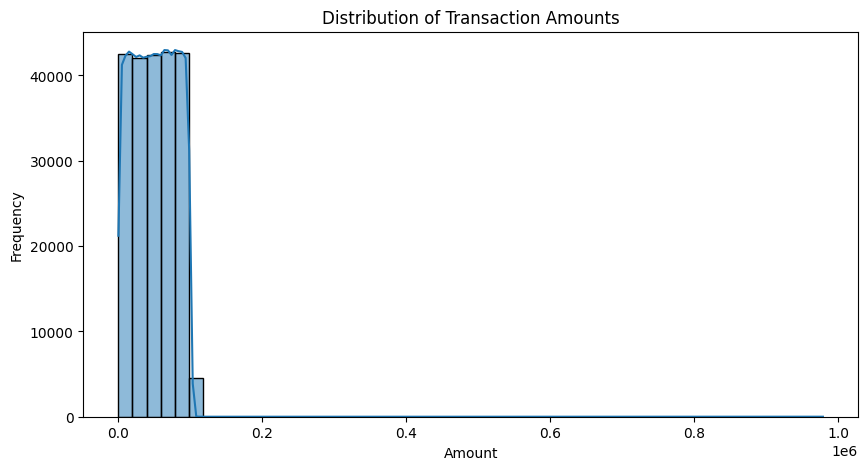

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

if 'category' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='category', y='amount', data=df)
    plt.title("Transaction Amount by Category")
    plt.xticks(rotation=45)
    plt.show()


In [25]:
df['z_score'] = (df['Amount'] - df['Amount'].mean()) / df['Amount'].std()

df['z_anomaly'] = df['z_score'].apply(lambda x: 1 if abs(x) > 3 else 0)

z_anomalies = df[df['z_anomaly'] == 1]
z_anomalies.head()


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,z_score,z_anomaly
2775,03-01-2023 06:15,TXN1049,ACC14,978942.26,MerchantJ,Transfer,New York,31.921619,1
3448,03-01-2023 17:28,TXN827,ACC12,712076.97,MerchantA,Withdrawal,Tokyo,22.750330,1
3453,03-01-2023 17:33,TXN1690,ACC8,489492.30,MerchantF,Purchase,Tokyo,15.100822,1
4148,04-01-2023 05:08,TXN625,ACC1,187344.37,MerchantD,Purchase,San Francisco,4.716984,1
4194,04-01-2023 05:54,TXN667,ACC3,272990.11,MerchantE,Transfer,Los Angeles,7.660348,1


In [26]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.01, random_state=42)
df['if_anomaly'] = clf.fit_predict(df[['Amount']])

df['if_anomaly'] = df['if_anomaly'].apply(lambda x: 1 if x == -1 else 0)

if_anomalies = df[df['if_anomaly'] == 1]
if_anomalies.head()


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,z_score,z_anomaly,if_anomaly
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London,-1.718411,0,1
142,01-01-2023 10:22,TXN831,ACC13,269.48,MerchantD,Purchase,New York,-1.712169,0,1
246,01-01-2023 12:06,TXN546,ACC14,33.75,MerchantB,Transfer,Los Angeles,-1.720271,0,1
272,01-01-2023 12:32,TXN1055,ACC7,524.47,MerchantE,Withdrawal,San Francisco,-1.703406,0,1
281,01-01-2023 12:41,TXN459,ACC10,112.94,MerchantB,Withdrawal,San Francisco,-1.717549,0,1


In [27]:
from sklearn.metrics import classification_report

if 'is_anomaly' in df.columns:
    print(" Z-score method:")
    print(classification_report(df['is_anomaly'], df['z_anomaly']))

    print("\n Isolation Forest method:")
    print(classification_report(df['is_anomaly'], df['if_anomaly']))


In [28]:
df[df['z_anomaly'] == 1].to_csv("z_score_anomalies.csv", index=False)
df[df['if_anomaly'] == 1].to_csv("iforest_anomalies.csv", index=False)


In [29]:

merchant_anomalies = df[df['if_anomaly'] == 1]['Merchant'].value_counts().head(10)
print("Top 10 Merchants with Anomalies:\n", merchant_anomalies)

location_anomalies = df[df['if_anomaly'] == 1]['Location'].value_counts().head(10)
print("Top 10 Locations with Anomalies:\n", location_anomalies)


Top 10 Merchants with Anomalies:
 Merchant
MerchantI    245
MerchantC    223
MerchantD    222
MerchantG    216
MerchantB    213
MerchantF    213
MerchantJ    199
MerchantE    194
MerchantA    194
MerchantH    190
Name: count, dtype: int64
Top 10 Locations with Anomalies:
 Location
San Francisco    453
Tokyo            434
New York         426
London           402
Los Angeles      394
Name: count, dtype: int64


In [30]:

df['combined_anomaly'] = df.apply(lambda row: 1 if row['z_anomaly'] == 1 and row['if_anomaly'] == 1 else 0, axis=1)
combined_anomalies = df[df['combined_anomaly'] == 1]
print("Combined high-confidence anomalies:", combined_anomalies.shape[0])
combined_anomalies.head()


Combined high-confidence anomalies: 11


,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,z_score,z_anomaly,if_anomaly,combined_anomaly
2775,03-01-2023 06:15,TXN1049,ACC14,978942.26,MerchantJ,Transfer,New York,31.921619,1,1,1
3448,03-01-2023 17:28,TXN827,ACC12,712076.97,MerchantA,Withdrawal,Tokyo,22.750330,1,1,1
3453,03-01-2023 17:33,TXN1690,ACC8,489492.30,MerchantF,Purchase,Tokyo,15.100822,1,1,1
4148,04-01-2023 05:08,TXN625,ACC1,187344.37,MerchantD,Purchase,San Francisco,4.716984,1,1,1
4194,04-01-2023 05:54,TXN667,ACC3,272990.11,MerchantE,Transfer,Los Angeles,7.660348,1,1,1


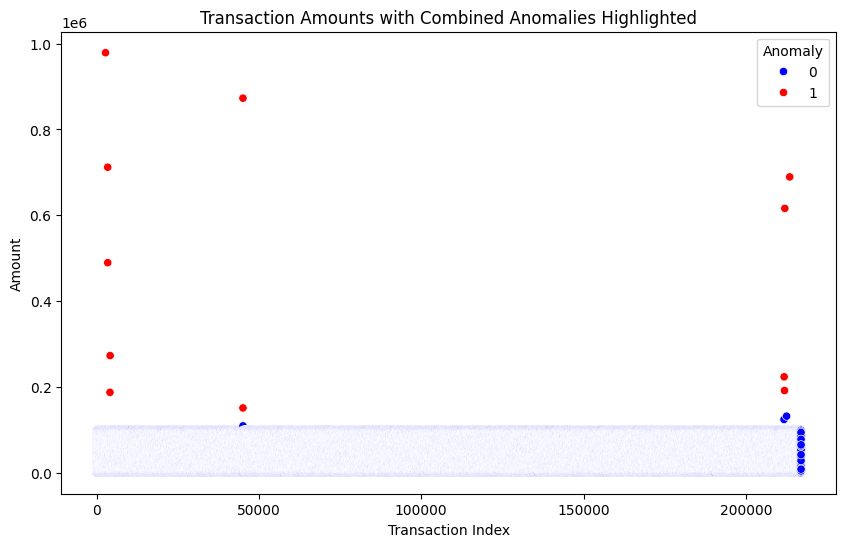

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index, y='Amount', data=df, hue='combined_anomaly', palette=['blue', 'red'])
plt.title("Transaction Amounts with Combined Anomalies Highlighted")
plt.xlabel("Transaction Index")
plt.ylabel("Amount")
plt.legend(title='Anomaly')
plt.show()


In [31]:
combined_anomalies.to_excel("C:\\Users\\Saloni Deshmukh\\Desktop\\financial_anomaly_audit_report.xlsx", index=False)
print(" Audit report saved to Desktop.")


 Audit report saved to Desktop.


In [32]:
print("Anomaly percentage:", round((df['combined_anomaly'].sum() / len(df)) * 100, 2), "%")
print("Most common transaction types among anomalies:")
print(combined_anomalies['TransactionType'].value_counts())


Anomaly percentage: 0.01 %
Most common transaction types among anomalies:
TransactionType
Purchase      5
Transfer      3
Withdrawal    3
Name: count, dtype: int64
